# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import random

import DataScienceHelperLibrary as dsh

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [2]:
# Show df to get an idea of the data

dsh.AnalyzeDataFrame(df)

-------------------- Dataframe analysis started --------------------
Shape:  (45993, 3)
Number of duplicate rows:  12311
-------------------- Analysis of Columns with NaN values --------------------
Columns having all values: 2, 66.67%
article_id, type: float64    0.0
title, type: object          0.0
dtype: float64
Columns having > 0% and <= 5% missing values: 1, 33.33%
email, type: object    0.00037
dtype: float64
-------------------- Analysis of Columns with NaN values finished --------------------
-------------------- Dataframe value counts analye started --------------------
********************  ********************
More than 20 different values:  714
Name:  article_id , dtype:  int64
********************  ********************
********************  ********************
More than 20 different values:  714
Name:  title , dtype:  int64
********************  ********************
********************  ********************
More than 20 different values:  5148
Name:  email , dtype:  int6

In [3]:
dsh.DfTailHead(df, count = 5)

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2
45988,1324.0,ibm watson facebook posts for 2015,d21b998d7a4722310ceeaa3c6aaa181a36db2d73
45989,142.0,neural networks for beginners: popular types a...,d21b998d7a4722310ceeaa3c6aaa181a36db2d73
45990,233.0,bayesian nonparametric models – stats and bots,4faeed980a7cd11e0f3cf2058cc04daa2ef11452
45991,1160.0,analyze accident reports on amazon emr spark,abbf639ba05daa5249c520e290283a6d726ba78d
45992,16.0,higher-order logistic regression for large dat...,1f18e8aaccd6c8720180c3fe264c8aef5b00697f


In [4]:
# Show df_content to get an idea of the data
print(df_content.shape)

(1056, 5)


In [5]:
dsh.DfTailHead(df_content, count = 5)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
1054,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049
1055,Homepage Follow Sign in / Sign up Homepage * H...,Once you get used to developing in a Notebook ...,"Jupyter Notebooks with Scala, Python, or R Ker...",Live,1050


### Some data preparation before use

In [6]:
dfUser = pd.DataFrame({'email': df['email'].unique()})
dfUser.reset_index(inplace = True)
dfUser = dsh.RenameColumn(dfUser, 'index', 'userid')
dfUser['userid'] = dfUser['userid'].apply(lambda x: x + 1)
dirUser = dict(zip(dfUser['email'], dfUser['userid']))

df['userid'] = df['email'].apply(lambda x: dirUser[x])
df.drop('email', axis = 1, inplace = True)

dsh.DfTailHead(df, count = 5)

,article_id,title,userid
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5
45988,1324.0,ibm watson facebook posts for 2015,5146
45989,142.0,neural networks for beginners: popular types a...,5146
45990,233.0,bayesian nonparametric models – stats and bots,5147
45991,1160.0,analyze accident reports on amazon emr spark,5148
45992,16.0,higher-order logistic regression for large dat...,5149


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

(0.0, 150)

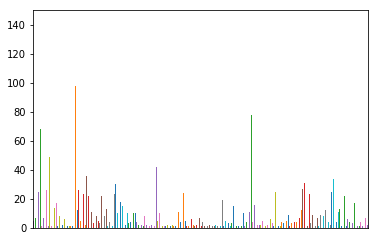

In [7]:
grpUser = df.groupby('userid')
numberUserRatings = {}
for ind, grp in grpUser:
    numberUserRatings[ind] = len(grp)

dfUserArticles = pd.DataFrame({'userid' : list(numberUserRatings.keys()), 'articlecount' : list(numberUserRatings.values())}, index = list(numberUserRatings) )

ax = dfUserArticles['articlecount'].plot(kind = 'bar')
ax.get_xaxis().set_ticks([])
plt.ylim(top = 150)

[]

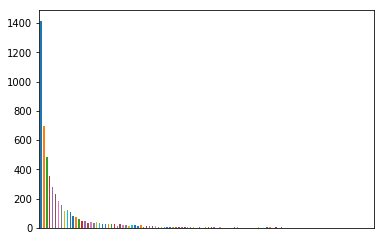

In [8]:
grpNbrRating = dfUserArticles.groupby('articlecount')

numberRatingUsers = {}
for ind, grp in grpNbrRating:
    numberRatingUsers[ind] = len(grp)

dfNumbRatingUsers = pd.DataFrame({'ratings' : list(numberRatingUsers.keys()), 'users' : list(numberRatingUsers.values())})

ax = dfNumbRatingUsers['users'].plot(kind = 'bar')
ax.get_xaxis().set_ticks([])

Circa 1500 users gave one rating, nearly 800 gave 2, and so on.

In [9]:
dfUserArticles['articlecount'].mean(), dfUserArticles['articlecount'].max()

(8.932414060982715, 364)

In [10]:
# Fill in the median and maximum number of user_article interactios below

median_val = dfUserArticles['articlecount'].median() # 50% of individuals interact with 9 number of articles or fewer.

max_views_by_user = dfUserArticles['articlecount'].max() # The maximum number of user-article interactions by any 1 user is 364.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [11]:
dsh.AnalyzeDataFrame(df_content)

-------------------- Dataframe analysis started --------------------
Shape:  (1056, 5)
Number of duplicate rows:  0
-------------------- Analysis of Columns with NaN values --------------------
Columns having all values: 3, 60.00%
doc_full_name, type: object    0.0
doc_status, type: object       0.0
article_id, type: int64        0.0
dtype: float64
Columns having > 0% and <= 5% missing values: 2, 40.00%
doc_body, type: object           0.013258
doc_description, type: object    0.002841
dtype: float64
-------------------- Analysis of Columns with NaN values finished --------------------
-------------------- Dataframe value counts analye started --------------------
********************  ********************
More than 20 different values:  1036
Name:  doc_body , dtype:  int64
********************  ********************
********************  ********************
More than 20 different values:  1022
Name:  doc_description , dtype:  int64
********************  ********************
**********

In [12]:
dsh.DfTailHead(df_content, count=5)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
1054,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049
1055,Homepage Follow Sign in / Sign up Homepage * H...,Once you get used to developing in a Notebook ...,"Jupyter Notebooks with Scala, Python, or R Ker...",Live,1050


In [13]:
df_content.drop('doc_status', axis = 1, inplace = True)

In [14]:
print(df_content.shape, df_content.drop_duplicates().shape)

(1056, 4) (1056, 4)


Well, that didn't work...

In [15]:
# Find and explore duplicate articles

vc = df_content['article_id'].value_counts()

df_content[df_content.article_id.isin(list(vc[vc > 1].index))].sort_values(by = 'article_id')

,doc_body,doc_description,doc_full_name,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,577


In [16]:
df_content = dsh.RemoveDuplicateRowsByColumn(df_content, 'article_id')

-------------------- Removing duplicate rows --------------------
Rows removed:  5
Values that are now unique:  [50, 221, 232, 398, 577]
-------------------- - --------------------


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [17]:
unique_articles = len(df['article_id'].unique()) # The number of unique articles that have at least one interaction
total_articles = len(df_content['article_id'].unique()) # The number of unique articles on the IBM platform

# Get id for users with no email adress
val = dfUser[dfUser['email'].isna()].values[0][0]
                      
unique_users = df[df['userid'] != val]['userid'].unique().shape[0] # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [18]:
grpArt = df.groupby('article_id')
maxArticle = 0
maxKey = None

for key, grp in grpArt:
    if len(grp) > maxArticle:
        maxArticle = len(grp)
        maxKey = key

df[df['article_id'] == maxKey].shape

(937, 3)

In [19]:
df_content.head()

,doc_body,doc_description,doc_full_name,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,4


In [20]:
most_viewed_article_id = maxKey # The most viewed article in the dataset as a string with one value following the decimal 
max_views = maxArticle # The most viewed article in the dataset was viewed how many times?

##### Remark
I already converted the values at beginning of the notebook because I didn't know that you provide code for that.

In [21]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': int(median_val),
    '`The total number of user-article interactions in the dataset is ______.`': int(user_article_interactions),
    '`The maximum number of user-article interactions by any 1 user is ______.`': int(max_views_by_user),
    '`The most viewed article in the dataset was viewed _____ times.`': int(max_views),
    '`The article_id of the most viewed article is ______.`': str(most_viewed_article_id),
    '`The number of unique articles that have at least 1 rating ______.`': int(unique_articles),
    '`The number of unique users in the dataset is ______`': int(unique_users),
    '`The number of unique articles on the IBM platform`': int(total_articles)
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [22]:
vc = df['article_id'].value_counts()

ser = vc.sort_values(ascending = False)

ser.head(10)

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
Name: article_id, dtype: int64

##### Remark
I changed the order of the following functions because I use get..ids in get..articles.

In [23]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    # Your code here
    vc = df['article_id'].value_counts().sort_values(ascending = False).head(n)
    
    top_articles = list(vc.index)
        
    return top_articles # Return the top article ids

def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    ids = get_top_article_ids(n, df)
    top_articles = list(df[df['article_id'].isin(ids)]['title'])
    
    return top_articles # Return the top article titles from df (not df_content)



In [24]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'use deep learning for image classification', 'healthcare python streaming application demo', 'healthcare python streaming application demo', 'apache spark lab, part 1: basic concepts', 'healthcare python streaming application demo', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use deep learning for image classification', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'visualize car data with brunel', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'insights from new york car accident reports', 'use xgboost, s

In [25]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [26]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    
    dfcopy = dsh.RemoveColumnsByWildcard(df, wildcards = ['title', 'email'])
    
    dfcopy = dfcopy.drop_duplicates().sort_values(by = 'userid')

    user_item = pd.crosstab(dfcopy['userid'], dfcopy['article_id'])
    
    # When reset_index() is used, prevent the column name to be "article_id"
    user_item.columns.name = None 
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

-------------------- Start finding and removing columns matchting to wildcards: ['title', 'email'] --------------------
Columns found to remove:  ['title']
-------------------- Finished removing columns matchting to wildcards --------------------


In [27]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [28]:
def find_similar_users(user_id, user_item=user_item, returnDfWithDotProd = False):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    dfcop = user_item.copy(deep = True)
    userValues = dfcop[dfcop.index == user_id].values
    dfcop['dotProd'] = dfcop.dot(userValues.transpose())
    dfcop = dfcop[dfcop['dotProd'] > 0]
    
    # sort by similarity
    dfcop.sort_values(by = 'dotProd', ascending = False, inplace = True)
    dfcop = dfcop[dfcop.index != user_id]
    
    if returnDfWithDotProd:
        return dfcop
    
    # create list of just the ids
    ids = list(dfcop.index)
       
    most_similar_users = ids
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [29]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 3782, 23, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 3782, 23, 4459, 203]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [30]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = df[df['article_id'].astype(str).isin(article_ids)]['title'].unique()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = []

    userRow =  user_item[user_item.index == user_id]
    
    arids = [aid for aid in list(userRow.columns) if userRow.iloc[0][aid] != 0]
    titles = list(df[df['article_id'].isin(arids)]['title'].unique())
    
    article_ids = [str(arid) for arid in arids]
    article_names = titles
    
    return article_ids, article_names # return the ids and names

#### Remark:
I extended the provided function "find_similar_users" with the parameter "returnDfWithDotProd" because of the note "Users who are the same closeness are chosen arbitrarily as the 'next' user" to have the chance to pick users randomly if dotproduct is the same.

Just returning a list of userids does not provice any information about equality of dotproduct from different users.

In [31]:
def user_user_recs(user_id, m=10, user_item = user_item):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    simUsers = find_similar_users(user_id = user_id, user_item = user_item, returnDfWithDotProd = True)
    if simUsers.shape[0] == 0:
        dsh.PrintLine('No similar users found for user_id: ', user_id)
        return []
    
    recs = []
    userKnow = get_user_articles(user_id)
    userKnowFlt = [float(uk) for uk in userKnow[0]]

    lstUserUnknownArt = []

    # Users with same closeness are choosen randomly

    # To provide this function, I need the df with dotproduct,
    # group by dotproduct, sort by key desc so that top users come first
    # and pick from each group the user/users randomly

    grpSimUsers = simUsers.groupby('dotProd')
    keysDesc = list(grpSimUsers.groups.keys())
    keysDesc.sort(reverse = True)

    # Iterate by highest to lowest dot product
    for maxProd in keysDesc:
        # get users having this dotproduct
        grp = grpSimUsers.get_group(maxProd).copy(deep = True)

        # don't recommend dotProd :)
        grp.drop('dotProd', axis = 1, inplace = True)

        # drop articles the user already knows
        grp.drop(columns = userKnowFlt, axis = 1, inplace = True)

        while True:
            # now pick user by index randomly
            randUserIndex = random.choice(grp.index)

            currentUser = grp[grp.index == randUserIndex]

            # Check if there are articles to recommend
            # drop user if there are no more articles
            # and continue with next user if there is one
            if currentUser.sum().sum() == 0:
                print('No more recommendations for userid: ', currentUser.index[0])
                grp.drop(index = randUserIndex, inplace = True)
                if grp.shape[0] == 0:
                    break
                continue

            # Now, if possible articles added to recommendations does not
            # exceed the limit, then add all
            if len(recs) + currentUser.sum().sum() <= m:
                for col in currentUser.columns:
                    # then add all possible articles
                    if currentUser.iloc[0][col] != 0:
                        recs.append(col)
                        userKnowFlt.append(col)

                        grp.drop(col, axis = 1, inplace = True)

            # else choose the last missing ones randomly
            else:

                lastPossibleArticles = [x for x in grp.columns if x not in userKnowFlt]
                needed = m - len(recs)
                lastFillup = random.choices(lastPossibleArticles, k = needed)

                recs += lastFillup

            if len(recs) == m:
                break

        if len(recs) == m:
                break
        
    recs = [str(rec) for rec in recs]
    return recs # return your recommendations for this user_id    

In [32]:
user_user_recs(20, 10)

['417.0',
 '1181.0',
 '1291.0',
 '482.0',
 '1337.0',
 '1329.0',
 '758.0',
 '1285.0',
 '1189.0',
 '437.0']

In [33]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

No more recommendations for userid:  3933


array(['apache spark lab, part 3: machine learning',
       'optimizing a marketing campaign: moving from predictions to actions',
       'shiny 0.12: interactive plots with ggplot2',
       'customer demographics and sales',
       'co2 emissions (metric tons per capita) by country',
       'web picks by dataminingapps', 'top analytics tools in 2016',
       'country surface area (sq. km)', 'ibm data catalog overview',
       'annual % inflation by country'], dtype=object)

In [34]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [35]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    simUsers = find_similar_users(
        user_id = user_id, 
        user_item = user_item, 
        returnDfWithDotProd = True
    ).sort_values(by = 'dotProd', ascending = False)

    simUsers = dsh.SelectColumnsByWildcard(simUsers, ['userid', 'dotProd'])
    simUsers = dsh.RenameColumn(simUsers, 'dotProd', 'similarity')
    
    simUsers = simUsers.reset_index()
    simUsers = dsh.RenameColumn(simUsers, 'userid', 'neighbor_id')
    
    simUsers['num_interactions'] = simUsers['neighbor_id'].apply(
        
        # Consider each article the user interacted with only once
        lambda x: len(df[df['userid'] == x]['article_id'].unique())
        
        # Consider each article the user interacted (means that if a user read
        # 1000 times an article, the user interaction count would be that high...
        # but that metric is nonsens
        #lambda x: df[df['userid'] == x].shape[0]
    )
    
    neighbors_df = simUsers.sort_values(['similarity', 'num_interactions'], ascending=[False, False])
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10, user_item = user_item):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    recs, rec_names = [], []
    
    userKnow = get_user_articles(user_id)
    userKnowFlt = [float(uk) for uk in userKnow[0]]
    
    dfTopUsers = get_top_sorted_users(user_item = user_item, user_id = user_id).copy(deep = True)
    
    mode = 1
    
    if mode == 0:
        
        # For each neighbor from best to worst
        for ind, row in dfTopUsers.iterrows():
            nb = row['neighbor_id']
        
            dfArticles = df[df['userid'] == nb].drop_duplicates()
            dfArticles = dfArticles[~dfArticles['article_id'].isin(userKnowFlt)]

            dfArticles['article_interactions'] = df['article_id'].apply(
                # Same situation as before:
                # take unique userids to prevent high rating if
                # an user read an article 1000 times
                lambda x: len(df[df['article_id'] == x]['userid'].unique())
            )
        
            dfArticles = dfArticles.sort_values(by = 'article_interactions', ascending = False)

            for aind, arow in dfArticles.iterrows():
                artId = arow['article_id']
                if artId in userKnowFlt:
                    continue
                
                recs.append(artId)
                rec_names.append(arow['title'])
                userKnowFlt.append(artId)
            
                if len(recs) == m:
                    break
            if len(recs) == m:
                break
                
                
    elif mode == 1:
    
        dfArticles = df[df['userid'].isin(dfTopUsers['neighbor_id'])].drop_duplicates()
        dfArticles = dfArticles[~dfArticles['article_id'].isin(userKnowFlt)]

        dfArticles['article_interactions'] = df['article_id'].apply(
            # Same situation as before:
            # take unique userids to prevent high rating if
            # an user read an article 1000 times
            lambda x: len(df[df['article_id'] == x]['userid'].unique())
        )

        #return dfArticles
        dfTopRec = dfTopUsers.merge(
            dfArticles,
            left_on = 'neighbor_id',
            right_on = 'userid',
            how = 'inner'
        )

        # Now that we have unique user interactions and unique article interactions.
        # I multiply both numbers with each other to be able to consider both:
        # users that have the most article interactions
        # and articles with the most total interaction
        dfTopRec['suminteractions'] = dfTopRec['num_interactions'] * dfTopRec['article_interactions']
        dfTopRec = dfTopRec.sort_values(by = 'suminteractions', ascending = False)

        for ind, row in dfTopRec[['article_id', 'title']].drop_duplicates().iterrows():
            artId = row['article_id']
            print('current article id: ', artId)
            if artId in recs:
                continue
            
            recs.append(artId)
            rec_names.append(row['title'])
            
            if len(recs) == m:
                break
        
    return recs, rec_names

In [36]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

-------------------- Start finding and keeping columns matchting to wildcards: ['userid', 'dotProd'] --------------------
-------------------- Finished keeping columns matchting to wildcards: 1 --------------------
current article id:  1330.0
current article id:  1429.0
current article id:  1364.0
current article id:  1314.0
current article id:  1427.0
current article id:  43.0
current article id:  1160.0
current article id:  1351.0
current article id:  1368.0
current article id:  1170.0
The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1429.0, 1364.0, 1314.0, 1427.0, 43.0, 1160.0, 1351.0, 1368.0, 1170.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use deep learning for image classification', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'deep learning with ten

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [37]:
get_top_sorted_users(user_id = 1).iloc[0]['neighbor_id']

-------------------- Start finding and keeping columns matchting to wildcards: ['userid', 'dotProd'] --------------------
-------------------- Finished keeping columns matchting to wildcards: 1 --------------------


3933

In [38]:
get_top_sorted_users(user_id = 131).iloc[10]['neighbor_id']

-------------------- Start finding and keeping columns matchting to wildcards: ['userid', 'dotProd'] --------------------
-------------------- Finished keeping columns matchting to wildcards: 1 --------------------


242

In [39]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(user_id = 1).iloc[0]['neighbor_id'] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(user_id = 131).iloc[10]['neighbor_id'] # Find the 10th most similar user to user 131

-------------------- Start finding and keeping columns matchting to wildcards: ['userid', 'dotProd'] --------------------
-------------------- Finished keeping columns matchting to wildcards: 1 --------------------
-------------------- Start finding and keeping columns matchting to wildcards: ['userid', 'dotProd'] --------------------
-------------------- Finished keeping columns matchting to wildcards: 1 --------------------


In [40]:
user1_most_sim,user131_10th_sim

(3933, 242)

In [41]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

#### Answer:

Naively answered, None of them because each function requires a user id that has at least one interaction with an article so that the dot product of this user (a) with others (b) can be  at least equal to 1 so that those users are taken into consideration to prepare a list of recommended articles these users read but not this user (a).

In [42]:
get_top_sorted_users(131)

-------------------- Start finding and keeping columns matchting to wildcards: ['userid', 'dotProd'] --------------------
-------------------- Finished keeping columns matchting to wildcards: 1 --------------------


,neighbor_id,similarity,num_interactions
0,3870,74,75
1,3782,39,135
2,23,38,135
3,203,33,96
4,4459,33,96
8,49,29,101
5,3697,29,100
6,3764,29,97
7,98,29,97
10,3910,25,60


`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

As there are no answers, in my view, the most reliable way is to recommend most viewed articles.

In [43]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

# Get top articles
print(df.drop_duplicates()['article_id'].value_counts().head(15))
print(df['article_id'].value_counts().head(15))

1330.0    467
1429.0    397
1364.0    388
1314.0    345
1398.0    329
1431.0    320
1271.0    314
1427.0    308
43.0      299
1160.0    299
1351.0    288
1336.0    284
1304.0    282
1436.0    282
1368.0    280
Name: article_id, dtype: int64
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
1436.0    481
1271.0    473
1398.0    465
43.0      460
1351.0    457
Name: article_id, dtype: int64


In [44]:
new_user_recs = [str(artId) for artId in df['article_id'].value_counts().index[:10]] # Your recommendations here

set(new_user_recs)

{'1162.0',
 '1170.0',
 '1293.0',
 '1304.0',
 '1314.0',
 '1330.0',
 '1364.0',
 '1427.0',
 '1429.0',
 '1431.0'}

In [45]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [46]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [47]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [48]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [49]:
# quick look at the matrix
dsh.AnalyzeDataFrame(user_item_matrix)

-------------------- Dataframe analysis started --------------------
Shape:  (5149, 714)
Number of duplicate rows:  1328
-------------------- Analysis of Columns with NaN values --------------------
Columns having all values: 714, 100.00%
article_id
0.0, type: float64       0.0
100.0, type: float64     0.0
1000.0, type: float64    0.0
1004.0, type: float64    0.0
1006.0, type: float64    0.0
1008.0, type: float64    0.0
101.0, type: float64     0.0
1014.0, type: float64    0.0
1015.0, type: float64    0.0
1016.0, type: float64    0.0
1017.0, type: float64    0.0
1018.0, type: float64    0.0
102.0, type: float64     0.0
1024.0, type: float64    0.0
1025.0, type: float64    0.0
1028.0, type: float64    0.0
103.0, type: float64     0.0
1030.0, type: float64    0.0
1035.0, type: float64    0.0
1038.0, type: float64    0.0
1042.0, type: float64    0.0
1043.0, type: float64    0.0
1044.0, type: float64    0.0
1047.0, type: float64    0.0
1048.0, type: float64    0.0
1050.0, type: float64    

0.0    5132
1.0      17
Name: 1177.0, dtype: int64
********************  ********************
********************  ********************
0.0    5119
1.0      30
Name: 1178.0, dtype: int64
********************  ********************
********************  ********************
0.0    5143
1.0       6
Name: 1179.0, dtype: int64
********************  ********************
********************  ********************
0.0    5090
1.0      59
Name: 1180.0, dtype: int64
********************  ********************
********************  ********************
0.0    5076
1.0      73
Name: 1181.0, dtype: int64
********************  ********************
********************  ********************
0.0    5040
1.0     109
Name: 1183.0, dtype: int64
********************  ********************
********************  ********************
0.0    5089
1.0      60
Name: 1184.0, dtype: int64
********************  ********************
********************  ********************
0.0    4894
1.0     255
Name: 1185.0, dty

********************  ********************
0.0    5147
1.0       2
Name: 1378.0, dtype: int64
********************  ********************
********************  ********************
0.0    5082
1.0      67
Name: 138.0, dtype: int64
********************  ********************
********************  ********************
0.0    5027
1.0     122
Name: 1386.0, dtype: int64
********************  ********************
********************  ********************
0.0    5129
1.0      20
Name: 1387.0, dtype: int64
********************  ********************
********************  ********************
0.0    5147
1.0       2
Name: 1390.0, dtype: int64
********************  ********************
********************  ********************
0.0    5025
1.0     124
Name: 1391.0, dtype: int64
********************  ********************
********************  ********************
0.0    4931
1.0     218
Name: 1393.0, dtype: int64
********************  ********************
********************  ********************

********************  ********************
0.0    5140
1.0       9
Name: 330.0, dtype: int64
********************  ********************
********************  ********************
0.0    5071
1.0      78
Name: 336.0, dtype: int64
********************  ********************
********************  ********************
0.0    5115
1.0      34
Name: 337.0, dtype: int64
********************  ********************
********************  ********************
0.0    5130
1.0      19
Name: 339.0, dtype: int64
********************  ********************
********************  ********************
0.0    5063
1.0      86
Name: 34.0, dtype: int64
********************  ********************
********************  ********************
0.0    5128
1.0      21
Name: 346.0, dtype: int64
********************  ********************
********************  ********************
0.0    5127
1.0      22
Name: 347.0, dtype: int64
********************  ********************
********************  ********************
0.0   

********************  ********************
********************  ********************
0.0    5068
1.0      81
Name: 645.0, dtype: int64
********************  ********************
********************  ********************
0.0    5102
1.0      47
Name: 647.0, dtype: int64
********************  ********************
********************  ********************
0.0    5123
1.0      26
Name: 65.0, dtype: int64
********************  ********************
********************  ********************
0.0    5088
1.0      61
Name: 651.0, dtype: int64
********************  ********************
********************  ********************
0.0    5148
1.0       1
Name: 653.0, dtype: int64
********************  ********************
********************  ********************
0.0    5143
1.0       6
Name: 655.0, dtype: int64
********************  ********************
********************  ********************
0.0    5131
1.0      18
Name: 656.0, dtype: int64
********************  ********************
******

********************  ********************
********************  ********************
0.0    5053
1.0      96
Name: 969.0, dtype: int64
********************  ********************
********************  ********************
0.0    5147
1.0       2
Name: 972.0, dtype: int64
********************  ********************
********************  ********************
0.0    5140
1.0       9
Name: 973.0, dtype: int64
********************  ********************
********************  ********************
0.0    5148
1.0       1
Name: 974.0, dtype: int64
********************  ********************
********************  ********************
0.0    5084
1.0      65
Name: 975.0, dtype: int64
********************  ********************
********************  ********************
0.0    5132
1.0      17
Name: 977.0, dtype: int64
********************  ********************
********************  ********************
0.0    5022
1.0     127
Name: 98.0, dtype: int64
********************  ********************
******

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [50]:
user_item_matrix.describe()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
count,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,...,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000,5149.000000
mean,0.002331,0.001748,0.002136,0.001359,0.002719,0.002331,0.015343,0.020392,0.000971,0.011070,...,0.003302,0.024665,0.023305,0.000194,0.000777,0.002331,0.005050,0.003690,0.010099,0.000777
std,0.048224,0.041776,0.046176,0.036850,0.052078,0.048224,0.122924,0.141352,0.031150,0.104641,...,0.057370,0.155117,0.150887,0.013936,0.027864,0.048224,0.070887,0.060639,0.099995,0.027864
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

In [52]:
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

In [53]:
u

array([[-4.30899801e-02,  8.30671762e-03,  2.75704572e-02, ...,
        -1.50001061e-04,  9.16007427e-05, -5.71173046e-03],
       [-1.03765691e-02,  1.64771768e-02,  6.04781444e-03, ...,
         1.27178430e-03,  8.00126111e-04, -8.11936450e-04],
       [-4.98474594e-02,  1.44789670e-03, -1.64960631e-02, ...,
         1.89806159e-03,  5.21721013e-04,  2.32686486e-03],
       ...,
       [-3.22580101e-05, -7.76317124e-05,  5.55685276e-05, ...,
         9.30979284e-01, -1.47128473e-04, -7.06977398e-04],
       [-2.46741942e-03,  3.80247363e-03, -4.46702539e-03, ...,
        -1.15455256e-04,  9.93266613e-01, -4.90396363e-04],
       [-4.91946427e-04, -1.00943223e-03,  4.99509739e-04, ...,
        -2.96280539e-04, -9.91659116e-05,  9.68205424e-01]])

In [54]:
s

array([5.53457037e+01, 2.32486418e+01, 2.17600228e+01, 2.06583341e+01,
       1.99708867e+01, 1.95569462e+01, 1.91632342e+01, 1.87197508e+01,
       1.83438615e+01, 1.80639261e+01, 1.76377686e+01, 1.74335474e+01,
       1.74301733e+01, 1.70930876e+01, 1.67638529e+01, 1.64669871e+01,
       1.64559512e+01, 1.63068949e+01, 1.61666030e+01, 1.57444047e+01,
       1.57038805e+01, 1.55878977e+01, 1.55013389e+01, 1.53746023e+01,
       1.52212789e+01, 1.50401111e+01, 1.49482365e+01, 1.47737529e+01,
       1.46704332e+01, 1.46097896e+01, 1.45312074e+01, 1.44025711e+01,
       1.43073643e+01, 1.40654598e+01, 1.38995696e+01, 1.38576259e+01,
       1.37810084e+01, 1.36388289e+01, 1.36055830e+01, 1.35749215e+01,
       1.35196309e+01, 1.33503810e+01, 1.33107854e+01, 1.31843779e+01,
       1.30764996e+01, 1.30470484e+01, 1.29137238e+01, 1.28999043e+01,
       1.27923679e+01, 1.26848013e+01, 1.26361984e+01, 1.26069082e+01,
       1.24039390e+01, 1.23562882e+01, 1.22810586e+01, 1.21600337e+01,
      

In [55]:
vt

array([[-2.21822365e-03, -1.13697491e-03, -8.25820256e-03, ...,
        -7.89214713e-03, -2.78398235e-02, -3.49679488e-04],
       [ 2.07736845e-03,  3.86642452e-04,  1.51981454e-03, ...,
        -1.56120895e-02,  9.70825293e-04, -4.30034249e-04],
       [-4.32111291e-04,  2.46676561e-03,  4.28288891e-03, ...,
         1.20613591e-02,  1.21832171e-02,  1.08416259e-03],
       ...,
       [ 0.00000000e+00,  1.85048639e-16, -8.70704035e-17, ...,
        -1.01295613e-16,  4.71200353e-17,  5.14360479e-17],
       [ 0.00000000e+00,  2.52238862e-16, -6.18559279e-17, ...,
        -1.71309901e-17,  1.37433479e-18, -6.29273015e-17],
       [ 0.00000000e+00, -4.52438811e-17,  1.18423704e-16, ...,
        -4.25485968e-17, -8.29501134e-17,  4.63341839e-17]])

#### Answer:



In [56]:
user_item_matrix.isnull().sum().sum()

0

In [57]:
user_item_matrix.sum().sort_values().head()

article_id
1113.0    1.0
1119.0    1.0
1233.0    1.0
1072.0    1.0
1237.0    1.0
dtype: float64

In [58]:
user_item_matrix.sum(axis = 1).sort_values().head()

user_id
2575    1.0
2520    1.0
2522    1.0
2523    1.0
2524    1.0
dtype: float64

We can use SVD here because the user_item_matrix has no nan values, each movie has a rating and each user gave at least one rating.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

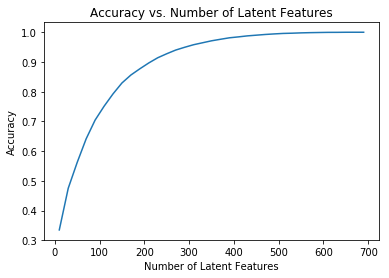

In [59]:
def CalcAccuracy(user_item, s, u, vt, num_latent_feats = np.arange(10,700+10,20)):
    num_latent_feats = np.arange(10,700+10,20)
    sum_errs = []

    for k in num_latent_feats:
        # restructure with k latent features
        s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

        # take dot product
        user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

        # compute error for each prediction to actual value
        diffs = np.subtract(user_item_matrix, user_item_est)

        # total errors and keep track of them
        err = np.sum(np.sum(np.abs(diffs)))
        sum_errs.append(err)


    plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
    plt.xlabel('Number of Latent Features');
    plt.ylabel('Accuracy');
    plt.title('Accuracy vs. Number of Latent Features');
    return sum_errs

errs = CalcAccuracy(user_item_matrix, s, u, vt)

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many movies can we make predictions for in the test set?  
* How many movies are we not able to make predictions for because of the cold start problem?

In [60]:
df_train = df.head(40000)
df_test = df.tail(5993)

In [73]:
df.shape, df.drop_duplicates().shape, df_train.shape, df_test.shape

((45993, 3), (33682, 3), (40000, 3), (5993, 3))

In [64]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here

    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index
    test_arts = user_item_test.index
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

-------------------- Start finding and removing columns matchting to wildcards: ['title', 'email'] --------------------
Columns found to remove:  ['title']
-------------------- Finished removing columns matchting to wildcards --------------------
-------------------- Start finding and removing columns matchting to wildcards: ['title', 'email'] --------------------
Columns found to remove:  ['title']
-------------------- Finished removing columns matchting to wildcards --------------------


In [65]:
user_item_test.index.isin(user_item_train.index).sum()

20

In [66]:
user_item_test.shape[0] - user_item_test.index.isin(user_item_train.index).sum()

662

In [67]:
user_item_test.columns.isin(user_item_train.columns).sum()

574

In [68]:
len(set(user_item_test.columns) - set(user_item_train.columns))

0

In [69]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [70]:
user_item_train[user_item_train.index.isin(user_item_test.index)]

,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
userid,,,,,,,,,,,,,,,,,,,,,
2917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3024,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3532,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3740,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
user_item_test[user_item_test.index.isin(user_item_train.index)]

,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
userid,,,,,,,,,,,,,,,,,,,,,
2917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3024,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3532,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3740,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
# Just for my understanding
user_item_test.loc[2917].sum(), user_item_train.loc[2917].sum(), df[df['userid'] == 2917].shape[0], len(df[df['userid'] == 2917]['article_id'].unique())

(2, 11, 17, 13)

User 2917 read 17 articles and 13 unique articles (so he read some articles more than one time). Two of these articles are labeled as 1 in train, the remaining 11 are labeled as 1 in the test data.

In [143]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [144]:
# get user subset

# As u, s, vt are Numpy arrays and the relevant user rows
# cannot be accessed via index (userid), I call reset_index()
# for both training and test user_item matrix and store the relevant
# indizes in dictionaries to be able to 
# select the relevant numpy rows via row index with user id

# {y:x for x,y in my_dict.iteritems()}
dirUserIdTest = {value:key for key, value in user_item_test.reset_index()['userid'].to_dict().items()}
dirUserIdTrain = {value:key for key, value in user_item_train.reset_index()['userid'].to_dict().items()}

dirUserIdTest = {key:value for key, value in dirUserIdTest.items() if key in dirUserIdTrain.keys()}
dirUserIdTrain = {key:value for key, value in dirUserIdTrain.items() if key in dirUserIdTest.keys()}

In [214]:
print(dirUserIdTest)
print(dirUserIdTrain)

{2917: 0, 3024: 1, 3093: 2, 3193: 3, 3527: 4, 3532: 5, 3684: 6, 3740: 7, 3777: 8, 3801: 9, 3968: 10, 3989: 11, 3990: 12, 3998: 13, 4002: 14, 4204: 15, 4231: 16, 4274: 17, 4293: 18, 4487: 19}
{2917: 2916, 3024: 3023, 3093: 3092, 3193: 3192, 3527: 3526, 3532: 3531, 3684: 3683, 3740: 3739, 3777: 3776, 3801: 3800, 3968: 3967, 3989: 3988, 3990: 3989, 3998: 3997, 4002: 4001, 4204: 4203, 4231: 4230, 4274: 4273, 4293: 4292, 4487: 4486}


In [146]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [147]:
user_item_train.shape, user_item_test.shape

((4487, 714), (682, 574))

In [207]:
# The test data contains 574 articles and train data 714 articles.
# 
# when calculating (test - pred)^2 for mse below.
# So I add the missing columns
for missing in [col for col in user_item_train.columns if col not in user_item_test.columns]:
    user_item_test[missing] = 0

user_item_test = user_item_test.sort_index(axis = 1)

(682, 714)
(682, 714)


In [287]:
dirErrs = {}
currentrow = None

dfResults = pd.DataFrame({
    'features' : [],
    'squarredError' : [],
    'userMSE' : [],
    'readArticles' : [],
    'userid' : []
})

for keepFeatures in range(5, user_item_train.shape[1]):
    print('Predicting for # features: ', keepFeatures)
    # set u, s, vt for used features
    u_feat = u_train[:, :keepFeatures]
    
    s_feat = np.zeros((keepFeatures, keepFeatures))
    s_feat[:keepFeatures, :keepFeatures] = np.diag(s_train[:keepFeatures])
    
    vt_feat = vt_train[:keepFeatures, :]
    
    # predict
    pred = np.dot(np.dot(u_feat, s_feat), vt_feat)
    
    dfPred = pd.DataFrame(pred, columns = user_item_train.columns, index = user_item_train.index)
    
    # pick the predicted user rows and calculate the mse as follows:
    
    sumErrs = []
    # my test for user '2917' above: read 17 articles, 13 unique articles, 11 in test data, 2 in train data
    for userid in dirUserIdTrain.keys():
        currentRow = user_item_test.loc[userid]
        currentPredRow = pred[dirUserIdTrain[userid]]
        
        # as we want to see how near our prediction is to an article we know the user read:
        userError = 0
        consideredArticles = 0
        for rind, rval in currentRow.iteritems():
            if rval == 0:
                consideredArticles += 1
            userError += (rval - dfPred[dfPred.index == userid][rind].values[0]) ** 2
        userError = userError / consideredArticles
        sumErrs.append(userError)
        
        dfResults.loc[dfResults.shape[0]] = [keepFeatures, userError, userError / consideredArticles, consideredArticles, userid]

    dirErrs[keepFeatures] = sumErrs

dfResults

Predicting for # features:  5
Predicting for # features:  6
Predicting for # features:  7
Predicting for # features:  8
Predicting for # features:  9
Predicting for # features:  10
Predicting for # features:  11
Predicting for # features:  12
Predicting for # features:  13
Predicting for # features:  14
Predicting for # features:  15
Predicting for # features:  16
Predicting for # features:  17
Predicting for # features:  18
Predicting for # features:  19
Predicting for # features:  20
Predicting for # features:  21
Predicting for # features:  22
Predicting for # features:  23
Predicting for # features:  24
Predicting for # features:  25
Predicting for # features:  26
Predicting for # features:  27
Predicting for # features:  28
Predicting for # features:  29
Predicting for # features:  30
Predicting for # features:  31
Predicting for # features:  32
Predicting for # features:  33
Predicting for # features:  34
Predicting for # features:  35
Predicting for # features:  36
Predicting fo

Predicting for # features:  265
Predicting for # features:  266
Predicting for # features:  267
Predicting for # features:  268
Predicting for # features:  269
Predicting for # features:  270
Predicting for # features:  271
Predicting for # features:  272
Predicting for # features:  273
Predicting for # features:  274
Predicting for # features:  275
Predicting for # features:  276
Predicting for # features:  277
Predicting for # features:  278
Predicting for # features:  279
Predicting for # features:  280
Predicting for # features:  281
Predicting for # features:  282
Predicting for # features:  283
Predicting for # features:  284
Predicting for # features:  285
Predicting for # features:  286
Predicting for # features:  287
Predicting for # features:  288
Predicting for # features:  289
Predicting for # features:  290
Predicting for # features:  291
Predicting for # features:  292
Predicting for # features:  293
Predicting for # features:  294
Predicting for # features:  295
Predicti

Predicting for # features:  522
Predicting for # features:  523
Predicting for # features:  524
Predicting for # features:  525
Predicting for # features:  526
Predicting for # features:  527
Predicting for # features:  528
Predicting for # features:  529
Predicting for # features:  530
Predicting for # features:  531
Predicting for # features:  532
Predicting for # features:  533
Predicting for # features:  534
Predicting for # features:  535
Predicting for # features:  536
Predicting for # features:  537
Predicting for # features:  538
Predicting for # features:  539
Predicting for # features:  540
Predicting for # features:  541
Predicting for # features:  542
Predicting for # features:  543
Predicting for # features:  544
Predicting for # features:  545
Predicting for # features:  546
Predicting for # features:  547
Predicting for # features:  548
Predicting for # features:  549
Predicting for # features:  550
Predicting for # features:  551
Predicting for # features:  552
Predicti

,features,squarredError,userMSE,readArticles,userid
0,5.0,0.003207,0.000005,712.0,2917.0
1,5.0,0.019099,0.000027,707.0,3024.0
2,5.0,0.007080,0.000010,709.0,3093.0
3,5.0,0.007944,0.000011,709.0,3193.0
4,5.0,0.001442,0.000002,713.0,3527.0
5,5.0,0.047177,0.000069,682.0,3532.0
6,5.0,0.015320,0.000022,711.0,3684.0
7,5.0,0.077216,0.000117,659.0,3740.0
8,5.0,0.001422,0.000002,713.0,3777.0
9,5.0,0.034362,0.000050,688.0,3801.0


In [288]:
from sqlalchemy import create_engine

engine = create_engine('sqlite:///{}'.format('PredictionResults.db'))

dfResults.to_sql('predictions', engine, index = False, if_exists = 'replace', chunksize = 4)

In [289]:
results = dfResults.copy(deep = True)

for grp in results.groupby('features'):
    print(grp.index, grp['userMSE'].astype(float).mean(), grp['readArticles'].astype(float).sum())
    #print(  np.sum(grp['userMSE']) / grp.shape[0] )
    print(grp)
    break

TypeError: tuple indices must be integers or slices, not str

In [268]:
invDirErrs = {np.sum(val):key for key, val in dirErrs.items()}

for key in dirErrs.keys():
    print(key, np.sum(dirErrs[key]))

5 17.836023231005456
6 17.78727353898562
7 17.936542595639175
8 17.69091833437194
9 17.786607478344898
10 17.719050461121935
11 17.726431750785878
12 17.673936593662543
13 17.80585025926205
14 17.642570926521408
15 17.659975798202538
16 17.510912076166367
17 17.471270740831706
18 17.530186085445244
19 17.50637198127161
20 17.531653531109782
21 17.55101542413046
22 17.540142815358486
23 17.367682549129515
24 17.364095705374222
25 17.38379418899437
26 17.275900147128606
27 17.272058055053233
28 17.241230166392718
29 17.18486002892877
30 17.202011651051507
31 17.068241347618724
32 17.11310074283441
33 17.02243914287683
34 17.08867130704593
35 17.105442649026337
36 17.01032184498529
37 17.02765247922201
38 16.997164933644356
39 16.925057836573384
40 16.85160471437216
41 16.853648082762202
42 16.86100430309251
43 16.824912665468627
44 16.77971797483208
45 16.76379971709301
46 16.717796897043673
47 16.642570290859947
48 16.609239651299696
49 16.60689194117246
50 16.576790409900315
51 16.5717

In [262]:
minVal = min(set(invDirErrs.keys()))

In [264]:
minVal, invDirErrs[minVal]

(164.40548324426229, 114)

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])